### Load libraries and Checking the TensorFlow Library Vesrion

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
plt.style.use('dark_background')
%matplotlib inline
import tensorflow as tf
tf.__version__

'2.15.0'

### Setting the Printing Precisions

In [2]:
np.set_printoptions(precision=2)


### Mount Google Drive in Colab Environment

In [3]:
## Mount Google drive folder if running in Colab
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


### Load diabetes data , named as diabetes_regression.csv

In [4]:
## Load diabetes dataset, the data set works as data matrix X
df = pd.read_csv('/content/drive/MyDrive/Project_Data_Sets/diabetes_regression.csv')

print('Diabetes dataset')
print('-----------')
print('Initial number of samples = %d'%(df.shape[0])) # Samples
print('Initial number of features = %d\n'%(df.shape[1])) # Features
df.head(5)

Diabetes dataset
-----------
Initial number of samples = 442
Initial number of features = 11



,AGE,GENDER,BMILEVEL,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,unhealthy,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,healthy,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,2,unhealthy,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,1,overweight,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,1,healthy,101.0,192,125.4,52.0,4.0,4.2905,80,135


### Create lists of ordinal, categorical, and continuous features

In [5]:
categorical_features = ['GENDER', 'BMILEVEL']
continuous_features = df.drop(categorical_features, axis = 1).columns.tolist()
print(categorical_features)
print(continuous_features)

['GENDER', 'BMILEVEL']
['AGE', 'BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'Y']


### Assign 'category' datatype to categorical columns

In [6]:
## Assign 'category' datatype to ordinal and categorical columns
print(df.dtypes)
df[categorical_features] = df[categorical_features].astype('category')
print('----')
df.dtypes

AGE           int64
GENDER        int64
BMILEVEL     object
BP          float64
S1            int64
S2          float64
S3          float64
S4          float64
S5          float64
S6            int64
Y             int64
dtype: object
----


AGE            int64
GENDER      category
BMILEVEL    category
BP           float64
S1             int64
S2           float64
S3           float64
S4           float64
S5           float64
S6             int64
Y              int64
dtype: object

### Remove the target variable column from the list of continuous features

In [7]:
## Remove the target variable column from the list of continuous features
continuous_features.remove('Y')

### Train and test split of the data

In [8]:
X = df.drop('Y', axis = 1)
y = df['Y']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

num_features = X_train.shape[1]
num_samples = X_train.shape[0]

print('Diabetes data set')
print('---------------------')
print('Number of training samples = %d'%(num_samples))
print('Number of features = %d'%(num_features))

Diabetes data set
---------------------
Number of training samples = 353
Number of features = 10


### Build pipeline for categorical and continuous features

In [9]:
## Build pipeline for categorical and continuous features

# Pipeline object for categorical (features
categorical_transformer = Pipeline(steps = [('onehotenc', OneHotEncoder(handle_unknown = 'ignore'))])

# Pipeline object for continuous features
continuous_transformer = Pipeline(steps = [('scaler', RobustScaler())])

# Create a preprocessor object for all features
preprocessor = ColumnTransformer(transformers = [('continuous', continuous_transformer, continuous_features),
                                                 ('categorical', categorical_transformer, categorical_features)
                                                ],
                                 remainder = 'passthrough'
                                 )

### Fit and transform train data using preprocessor followed by transforming test data

In [13]:
print(X_train.iloc[0, :])
print('------')
X_train_transformed = preprocessor.fit_transform(X_train)
print(X_train_transformed[0, :])

AGE              47
GENDER            2
BMILEVEL    healthy
BP             75.0
S1              225
S2            166.0
S3             42.0
S4              5.0
S5           4.4427
S6              102
Name: 438, dtype: object
------
[-0.16 -0.9   0.89  1.42 -0.35  0.5  -0.25  0.67  0.    1.    1.    0.
  0.    0.  ]


### Fit and transform train data using preprocessor

In [15]:
X_train_transformed = preprocessor.fit_transform(X_train).T
# Update number of features
num_features = X_train_transformed.shape[0]
# Transform training data using preprocessor
X_test_transformed = preprocessor.transform(X_test).T
# Convert Y_train and Y_test to numpy arrays
type(Y_train) # = Y_train.to_numpy()
type(Y_test) # = Y_test.to_numpy()

numpy.ndarray

### A generic layer class with forward and backward methods

In [16]:
class Layer:
  def __init__(self):
    self.input = None
    self.output = None

  def forward(self, input):
    pass

  def backward(self, output_gradient, learning_rate):
    pass

### Mean squared error (MSE) loss and its gradient

In [17]:
## Define the loss function and its gradient
def mse(Y, Yhat):
  return(np.mean(0.5*(Y - Yhat)**2))
  #TensorFlow in-built function for mean squared error loss
  #mse = tf.keras.losses.MeanSquaredError()
  #mse(Y, Yhat).numpy()

def mse_gradient(Y, Yhat):
  return(Yhat - Y)

### Generic activation layer class with Forward and Backward method

In [18]:
class Activation(Layer):
    def __init__(self, activation, activation_gradient):
        self.activation = activation
        self.activation_gradient = activation_gradient

    def forward(self, input):
        self.input = input
        self.output = self.activation(self.input)
        return(self.output)

    def backward(self, output_gradient, learning_rate = None):
        return(output_gradient[:-1, :] * self.activation_gradient(self.input))

### Example of Specific activation layer classes and their gradients

In [19]:
class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(z):
            return 1 / (1 + np.exp(-z))

        def sigmoid_gradient(z):
            a = sigmoid(z)
            return a * (1 - a)

        super().__init__(sigmoid, sigmoid_gradient)

class Tanh(Activation):
    def __init__(self):
        def tanh(z):
            return np.tanh(z)

        def tanh_gradient(z):
            a = np.tanh(z)
            return 1 - a**2

        super().__init__(tanh, tanh_gradient)

class ReLU(Activation):
    def __init__(self):
        def relu(z):
            return z * (z > 0)

        def relu_gradient(z):
            return 1. * (z > 0)

        super().__init__(relu, relu_gradient)

### Dense layer class and its Forward and Backward Method

In [20]:
## Dense layer class
class Dense(Layer):
    def __init__(self, input_size, output_size, reg_strength):
        self.weights = 0.01*np.random.randn(output_size, input_size+1) # bias trick
        self.weights[:, -1] = 0.01 # set all bias values to the same nonzero constant
        self.reg_strength = reg_strength
        self.reg_loss = None

    def forward(self, input):
        self.input = np.vstack([input, np.ones((1, input.shape[1]))]) # bias trick
        self.output= np.dot(self.weights, self.input)
        # Calculate regularization loss
        self.reg_loss = self.reg_strength * np.sum(self.weights[:, :-1] * self.weights[:, :-1])

    def backward(self, output_gradient, learning_rate):
        ## Following is the inefficient way of calculating the backward gradient
        #weights_gradient = np.zeros((self.output.shape[0], self.input.shape[0]), dtype = np.float64)
        #for b in range(output_gradient.shape[1]):
        #  weights_gradient += np.dot(output_gradient[:, b].reshape(-1, 1), self.input[:, b].reshape(-1, 1).T)
        #weights_gradient = (1/output_gradient.shape[1])*weights_gradient

        ## Following is the efficient way of calculating the weights gradient w.r.t. data
        weights_gradient = (1/output_gradient.shape[1])*np.dot(np.atleast_2d(output_gradient), np.atleast_2d(self.input).T)
        # Add the regularization gradient here
        weights_gradient += 2 * self.reg_strength * np.hstack([self.weights[:, :-1], np.zeros((self.weights.shape[0], 1))])


        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights = self.weights + learning_rate * (-weights_gradient)

        return(input_gradient)

### Function to generate sample indices for batch processing according to batch size

In [21]:
## Function to generate sample indices for batch processing according to batch size
def generate_batch_indices(num_samples, batch_size):
  # Reorder sample indices
  reordered_sample_indices = np.random.choice(num_samples, num_samples, replace = False)
  # Generate batch indices for batch processing
  batch_indices = np.split(reordered_sample_indices, np.arange(batch_size, len(reordered_sample_indices), batch_size))
  return(batch_indices)

### Train the 2-layer neural network (8 nodes followed by 1 node) using batch training with batch size = 16

In [22]:
## Train the 2 layer neural network (8 nodes followed by 1 node)
## using batch training with batch size = 100
learning_rate = 1e-03 # learning rate
batch_size = 16 # batch size
nepochs = 1000 # number of epochs
reg_strength = 0.5 # regularization strength
# Create empty array to store training losses over each epoch
loss_train_epoch = np.empty(nepochs, dtype = np.float64)
# Create empty array to store test losses over each epoch
loss_test_epoch = np.empty(nepochs, dtype = np.float64)


# Neural network architecture

dlayer1 = Dense(num_features, 8 , reg_strength) # define dense layer 1
alayer1 = ReLU() # ReLU activation layer 1
dlayer2 = Dense(8 , 1 , reg_strength) # define dense layer 2

# Steps: run over each sample in the batch, calculate loss, gradient of loss,
# and update weights.

epoch = 0
while epoch < nepochs:
  batch_indices = generate_batch_indices(num_samples, batch_size)
  loss = 0
  for b in range(len(batch_indices)):
    # Forward propagation for training data
    dlayer1.forward(X_train_transformed[:, batch_indices[b]]) # forward prop dense layer 1 with batch feature added
    alayer1.forward(dlayer1.output) # forward prop activation layer 1
    dlayer2.forward(alayer1.output) # forward prop dense layer 2
    # Calculate training data loss
    loss += mse(Y_train[batch_indices[b]], dlayer2.output)
    # Add the regularization losses
    loss += dlayer1.reg_loss + dlayer2.reg_loss

    # Backward prop starts here
    grad = mse_gradient(Y_train[batch_indices[b]], dlayer2.output)
    grad = dlayer2.backward(grad, learning_rate)
    grad = alayer1.backward(grad)
    grad = dlayer1.backward(grad, learning_rate)
  # Calculate the average training loss for the current epoch
  loss_train_epoch[epoch] = loss/len(batch_indices)

  # Forward propagation for test data
  dlayer1.forward(X_test_transformed)
  alayer1.forward(dlayer1.output)
  dlayer2.forward(alayer1.output)

  # Calculate test data loss plus regularization loss
  loss_test_epoch[epoch] =  mse(Y_test, dlayer2.output) + dlayer1.reg_loss + dlayer2.reg_loss

  print('Epoch %d: train loss = %f, test loss = %f'%(epoch+1, loss_train_epoch[epoch], loss_test_epoch[epoch]))
  epoch = epoch + 1

Epoch 1: train loss = 14191.800748, test loss = 12860.862244
Epoch 2: train loss = 7711.000657, test loss = 2225.091247
Epoch 3: train loss = 1651.970071, test loss = 1768.066679
Epoch 4: train loss = 1595.410520, test loss = 1922.745477
Epoch 5: train loss = 1650.514558, test loss = 1866.949418
Epoch 6: train loss = 1900.150536, test loss = 3658.987223
Epoch 7: train loss = 1978.437495, test loss = 2131.567737
Epoch 8: train loss = 1730.245174, test loss = 1929.802990
Epoch 9: train loss = 1630.153278, test loss = 1785.061127
Epoch 10: train loss = 1629.866709, test loss = 2467.957939
Epoch 11: train loss = 1807.793095, test loss = 2307.799165
Epoch 12: train loss = 1623.743306, test loss = 1755.660811
Epoch 13: train loss = 1669.727464, test loss = 2212.514324
Epoch 14: train loss = 1621.173213, test loss = 1877.797241
Epoch 15: train loss = 1577.824742, test loss = 1886.821763
Epoch 16: train loss = 1647.555552, test loss = 2002.068392
Epoch 17: train loss = 1683.620537, test loss =

### Plot training loss vs. epoch

Text(0.5, 1.0, 'Loss vs. Epoch for reg. strength 0.01')

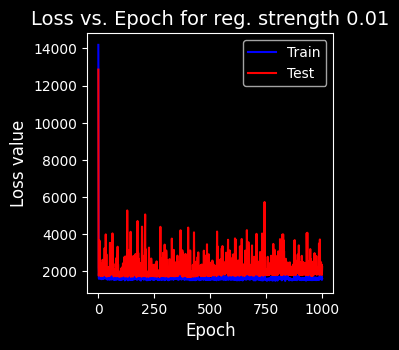

In [23]:
# Plot train and test loss as a function of epoch:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
fig.tight_layout(pad = 4.0)
ax.plot(loss_train_epoch , 'b', label = 'Train')
ax.plot(loss_test_epoch , 'r', label = 'Test')
ax.set_xlabel('Epoch', fontsize = 12)
ax.set_ylabel('Loss value', fontsize = 12)
ax.legend()
ax.set_title('Loss vs. Epoch for reg. strength 0.01', fontsize = 14)

### Test performance on test data

In [24]:
dlayer1.forward(X_test_transformed)
alayer1.forward(dlayer1.output)
dlayer2.forward(alayer1.output)
ypred = dlayer2.output.flatten()
ytrue = Y_test
np.column_stack((ytrue, ypred))

array([[ 78.  , 149.28],
       [152.  , 106.22],
       [200.  , 210.57],
       [ 59.  ,  87.2 ],
       [311.  , 201.41],
       [178.  , 214.79],
       [332.  , 253.42],
       [132.  , 123.33],
       [156.  , 157.72],
       [135.  , 163.95],
       [220.  , 258.53],
       [233.  , 224.94],
       [ 91.  , 115.3 ],
       [ 51.  ,  92.14],
       [195.  , 299.8 ],
       [109.  , 246.61],
       [217.  , 220.76],
       [ 94.  , 140.6 ],
       [ 89.  , 129.59],
       [111.  , 188.9 ],
       [129.  , 219.15],
       [181.  , 116.85],
       [168.  , 176.53],
       [ 97.  , 122.15],
       [115.  , 136.79],
       [202.  , 251.28],
       [ 84.  ,  99.04],
       [147.  , 207.69],
       [253.  , 164.42],
       [144.  , 220.08],
       [262.  , 185.86],
       [115.  , 188.61],
       [ 68.  , 229.43],
       [ 65.  , 104.02],
       [252.  , 194.09],
       [212.  , 222.02],
       [142.  , 138.65],
       [215.  , 302.48],
       [180.  , 207.11],
       [163.  , 196.18],
